The current paper draft has a figure that plots per-line computation time versus number of decision variables. To pack more information into this figure, Ian suggested I repeat the analysis for one or two more networks and add the results to the plot. He suggested a larger network to compare the RTS-96 against. The issue with using such a network is that wind farms must be carefully placed to secure a numerical solution from the algorithm (rather than `Infinity` or `NaN`).

If the Polish grid has only a few wind farms, we may be able to analyze lines between them, but the vast majority of lines will not return numerical solutions.

I modified my code to keep track of solution time for each QCQP instance. Testing:

In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in eval at ./sysimg.jl:14
 in anonymous at multi.jl:1350
 in anonymous at multi.jl:892
 in run_work_thunk at multi.jl:645
 [inlined code] from multi.jl:892
 in anonymous at task.jl:63
while loading /home/jkersulis/Documents/Dropbox/InstantonAnew/Jonas Edits/Time-Coupled Instanton/temporal-instanton/src/manipulations.jl, in expression starting on line 451
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in eval at ./sysimg.jl:14
 in anonymous at multi.jl:1350
 in anonymous at multi.jl:892
 in run_work_thunk at multi.jl:645
 [inlined code] from multi.jl:892
 in anonymous at task.jl:63
while loading /

In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton

 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/jkersulis/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/jkersulis/.julia/v0.4/IJulia/src/IJulia.jl:144
 in anonymous at task.jl:447
while loading /home/jkersulis/.julia/v0.4/MAT/src/MAT_HDF5.jl, in expression starting on line 281
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include at ./boot.jl:261
 in include_from_node1 

In [2]:
# compile everything with this run:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

sort(outputData.score)

in fillbuf at /home/jkersulis/.julia/v0.4/Zlib/src/Zlib.jl:264
in fillbuf at /home/jkersulis/.julia/v0.4/Zlib/src/Zlib.jl:264


104-element Array{Float64,1}:
    0.263788
    0.327316
    1.28861 
    2.20415 
    2.32297 
    2.42316 
    4.67876 
    4.86524 
    4.89917 
    5.67827 
    5.93862 
    6.43917 
    6.46089 
    ⋮       
  178.086   
  303.003   
  370.614   
  370.614   
  391.307   
  428.944   
  923.98    
  979.199   
 1319.85    
 1390.03    
 1967.27    
 1967.27    

9.488825 seconds (2.95 M allocations: 141.821 MB, 0.42% gc time)


In [3]:
include("../src/mat2tmpinst.jl")
case = "case96"
# maxLines = 10
reps = 50
line_times_96 = Vector{Vector{Float64}}()

for rep in 1:reps
    num_farms_vec = collect(2:2:72)
    gen_count = Vector{Int64}()
    mpc = loadcase(case,describe=false)
    push!(gen_count,length(unique(mpc["gen"][:,1])))

    score_output = Array(Vector{Float64},0)
    sec_elapsed = Vector{Float64}()
    line_times = Vector{Vector{Float64}}()
    bytes_alloc = Vector{Float64}()
    sec_in_gc = Vector{Float64}()
    wind_count = Vector{Int64}()

    for i in 1:length(num_farms_vec)
        num_farms = num_farms_vec[i]
        push!(wind_count,num_farms)
        penetration = 0.7
        d = mat2tmpinst(case,num_farms,penetration)

        # Thermal model parameters:
        d.Tamb = 35. # C
        d.T0 = 60. #46. # initial line steady-state temp

#         d.time_values = 0:600:3600 # one hour in 10-minute steps
#         d.int_length = 3600. # seconds = one hour
        d.time_values = 0:30:300 # five minutes in 30-sec steps
        d.int_length = 300. # seconds = 5 min

        Gp,Dp,Rp = (d.G0, d.D0, d.R0)
        d.G0 = [Gp;Gp;Gp;Gp;Gp;Gp]
        d.D0 = [Dp;Dp;Dp;Dp;Dp;Dp]
        d.R0 = [Rp;Rp;Rp;Rp;Rp;Rp]

        n = length(d.k)
        nr = length(d.Ridx)
        T = convert(Int64,length(d.G0)/n)

        timed_results = @timed solve_temporal_instanton(d);#,maxLines);
        results = timed_results[1]
        o = process_instanton_results(results,n,nr,T,return_as_type=true);
        push!(score_output,o.score)
        push!(sec_elapsed,timed_results[2])
        push!(bytes_alloc,timed_results[3])
        push!(sec_in_gc,timed_results[4])
        push!(line_times,o.linetimes)
    end

    # lines_processed = []
    # for score_vec in score_output
    #     push!(lines_processed, sum(score_vec.!=Inf))
    # end

    push!(line_times_96, [mean(line_times[i]) for i in 1:length(line_times)])
end

In [4]:
line_times_96

50-element Array{Array{Float64,1},1}:
 [0.0039068,0.00510604,0.00651918,0.0079063,0.0092515,0.0108353,0.017108,0.0159624,0.018717,0.0220169  …  0.172796,0.16657,0.228121,0.24763,0.228327,0.277969,0.289047,0.392143,0.278394,0.365801]      
 [0.0122951,0.0113803,0.00882993,0.00945509,0.0112724,0.0124714,0.024214,0.0184088,0.0218908,0.0278666  …  0.148818,0.165713,0.200156,0.219863,0.247398,0.235193,0.243539,0.259155,0.274869,0.351996]   
 [0.00501489,0.00641888,0.00971398,0.0129252,0.0154566,0.0146508,0.015866,0.0179876,0.0237229,0.0257819  …  0.148506,0.163688,0.179609,0.191762,0.291267,0.281121,0.269617,0.287454,0.336409,0.344751]  
 [0.00423563,0.00936655,0.00715534,0.00924441,0.010639,0.0140662,0.015609,0.0193623,0.0208399,0.0250016  …  0.186408,0.175149,0.179992,0.191803,0.319161,0.298473,0.267988,0.269164,0.280475,0.311025]  
 [0.00438814,0.00579709,0.00698658,0.00912884,0.0104832,0.0151648,0.0175311,0.0203512,0.0268328,0.0283471  …  0.153227,0.164712,0.183532,0.194372,0.212929,0.2

In [5]:
using JLD
save("../data/line_times_96.jld", "line_times_96", line_times_96)

In [16]:
include("../src/mat2tmpinst.jl")
case = "case2383wp"
maxLines = 10
reps = 2
line_times_2383 = Vector{Vector{Float64}}()

for rep in 1:reps
    num_farms_vec = collect(200:10:390)
    gen_count = Vector{Int64}()
    mpc = loadcase(case,describe=false)
    push!(gen_count,length(unique(mpc["gen"][:,1])))

    score_output = Array(Vector{Float64},0)
    sec_elapsed = Vector{Float64}()
    line_times = Vector{Vector{Float64}}()
    bytes_alloc = Vector{Float64}()
    sec_in_gc = Vector{Float64}()
    wind_count = Vector{Int64}()

    for i in 1:length(num_farms_vec)
        num_farms = num_farms_vec[i]
        println("wind farms: $num_farms")
        push!(wind_count,num_farms)
        penetration = 0.7
        d = mat2tmpinst(case,num_farms,penetration)

        # Thermal model parameters:
        d.Tamb = 35. # C
        d.T0 = 60. #46. # initial line steady-state temp

#         d.time_values = 0:600:3600 # one hour in 10-minute steps
#         d.int_length = 3600. # seconds = one hour
        
        d.time_values = 0:30:300 # five minutes in 30-sec steps
        d.int_length = 300. # seconds = 5 min
        
        Gp,Dp,Rp = (d.G0, d.D0, d.R0)
        d.G0 = [Gp;Gp;Gp;Gp;Gp;Gp]
        d.D0 = [Dp;Dp;Dp;Dp;Dp;Dp]
        d.R0 = [Rp;Rp;Rp;Rp;Rp;Rp]

        n = length(d.k)
        nr = length(d.Ridx)
        T = convert(Int64,length(d.G0)/n)

        timed_results = @timed solve_temporal_instanton(d,maxLines);
        results = timed_results[1]
        o = process_instanton_results(results,n,nr,T,return_as_type=true);
        push!(score_output,o.score)
        push!(sec_elapsed,timed_results[2])
        push!(bytes_alloc,timed_results[3])
        push!(sec_in_gc,timed_results[4])
        push!(line_times,o.linetimes)
    end

    lines_processed = []
    for score_vec in score_output
        push!(lines_processed, sum(score_vec.!=Inf))
    end

    push!(line_times_2383, [mean(line_times[i]) for i in 1:length(line_times)])
end

wind farms: 200


wind farms: 210
wind farms: 220


wind farms: 230


wind farms: 240


wind farms: 250


wind farms: 260


wind farms: 270


wind farms: 280
wind farms: 290


wind farms: 300


wind farms: 310


wind farms: 320
wind farms: 330
wind farms: 340


wind farms: 350


wind farms: 360


wind farms: 370


wind farms: 380


wind farms: 390


wind farms: 200


wind farms: 210


wind farms: 220


wind farms: 230


wind farms: 240


wind farms: 250


wind farms: 260


wind farms: 270


wind farms: 280


wind farms: 290


wind farms: 300
wind farms: 310


wind farms: 320


wind farms: 330
wind farms: 340


wind farms: 350


wind farms: 360


wind farms: 370
wind farms: 380


wind farms: 390


In [8]:
using PyPlot
PyPlot.svg(true)

true

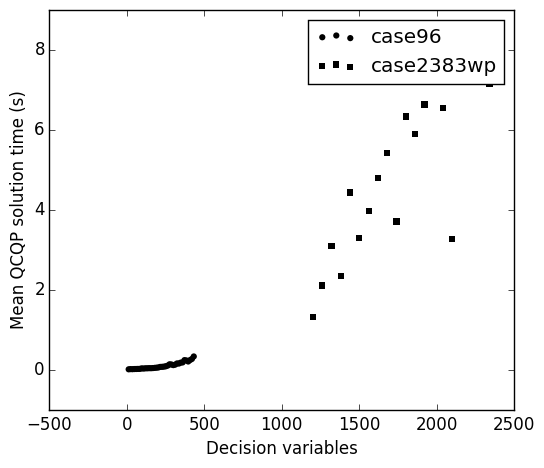

PyObject <matplotlib.text.Text object at 0x7f62fd5676a0>

In [23]:
fig = figure(figsize=(6,5))

x96 = collect(2:2:72)*6
y96 = mean(line_times_96) # s

x2383 = collect(200:10:390)*6
y2383 = mean(line_times_2383) # s

scatter(x96,y96,facecolor="black",alpha=1.,s=20,edgecolor="")
hold(true)
scatter(x2383,y2383,marker="s",facecolor="black",alpha=1.,s=20,edgecolor="")

legend(["case96";"case2383wp"])

# axis([0;450;0;250])
xlabel("Decision variables")
ylabel("Mean QCQP solution time (s)")
# xticks(size=10)
# yticks(size=10)


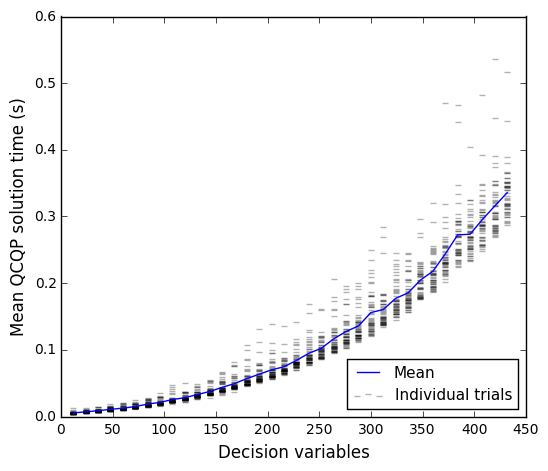

In [37]:
fig = figure(figsize=(6,5))
hold(true)

x96 = collect(2:2:72)*6

for i in 1:length(line_times_96)
    y96 = line_times_96[i]
    scatter(x96,y96,marker="_",facecolor="black",alpha=0.3)
end

plot(x96,mean(line_times_96))

legend(["Mean";"Individual trials"],loc=4,fontsize=11)

axis([0;450;0;0.6])
xlabel("Decision variables")
ylabel("Mean QCQP solution time (s)")
xticks(size=10)
yticks(size=10)
savefig("../paper2/images/rts-96-scaling-dots.pdf")

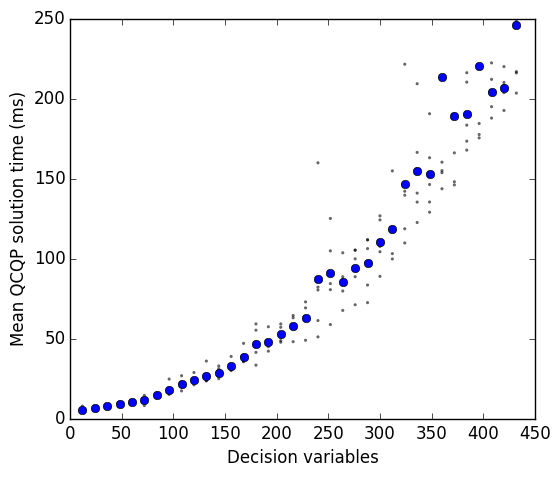

PyObject <matplotlib.text.Text object at 0x7efbeaea8978>

In [113]:
fig = figure(figsize=(6,5))
hold(true)

x = wind_count*6 # no. of decision vars
y = mean(line_times_agg)*1e3 # ms
yerr_u = [maximum([line_times_agg[i][j] for i in 1:reps]) for j in 1:36]
yerr_l = [minimum([line_times_agg[i][j] for i in 1:reps]) for j in 1:36]

scatter(x,y,facecolor="black",alpha=1.,s=20,edgecolor="")
errorbar(x,y,yerr=yerr_l,fmt="o")

for rep in 1:reps
    scatter(wind_count*6,line_times_agg[rep]*1e3,facecolor="black",alpha=0.6,s=5,edgecolor="")
    # yscale("log")
end


axis([0;450;0;250])
xlabel("Decision variables")
ylabel("Mean QCQP solution time (ms)")
# xticks(size=10)
# yticks(size=10)
